[View in Colaboratory](https://colab.research.google.com/github/Brogr4mmer/Week1_public/blob/master/AK_Mammogram_Analysis_Challenge.ipynb)

# Mammogram Analysis Challenge

A mammogram is an X-ray of the breast used primarily by radiologists to detect signs of breast cancer like abnormal masses and calcifications (signs of a possible tumor). Sometimes these abnormalities are obvious, sometimes they are not. In younger women especially, masses and calcifications can be difficult for radiologists to detect in a mammogram due to dense surrounding tissue. This makes mammograms a great candidate for machine learning analysis. A program that can detect abnormalities with high accuracy could be used to catch radiologists' mistakes and potentially save lives. 

For this challenge you will classify mammogram segments into two classes (positive for an abnormality and negative). You may also attempt to use the "complex labels" to classify the mammograms into 4 classes (negative, positive benign calcification, positive malignant calcification, positive benign mass, and positive malignant mass). We recommend you begin with the simple labels, but try both if you have time!

Below we provide you with code to visualize the dataset as well as a simple but functional model that does a relatively poor job at this classification problem. It's up to you to build a classifier that does better! Your models will be evaluated based on confusion matrix , Aread under the ROC Curve, and Creativity.

Before you run any code make sure you turn GPU support on! (Edit > Notebook Settings > Hardware Accelerator).

In [0]:
# Run this cell to import the packages you will need to unpack the dataset
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy
from io import BytesIO
from PIL import Image
import random
import pickle
import os
import zipfile
import scipy.ndimage
from google.colab import files
import tensorflow as tf

## Loading the Dataset

This dataset is from the publicly available Digital Database for Screening Mammography (DDSM) and the Curated Breast Imaging Subset of DDSM (CBIS-DDSM).

The simple labels are 0 (negative for an abnormality) and 1 (positive for an abnormality). The complex labels are:
* 0 = Negative
* 1 = Benign Calcification
* 2 = Benign Mass
* 3 = Malignant Calcification
* 4 = Malignant Mass



Run the cell below to get all the data for this challenge. After running the cell, the following data will be loaded into the following variables:
* **train_simple_labels**: 2 column pandas df where each row contains a label (0 or 1) and the unique ID of the image the label corresponds to. 5500 samples/rows.
* **train_complex_labels**: 2 column pandas df where the rows contains a label (0, 1, 2, 3, 4) and the unique ID of the image the label corresponds to. 5500 samples/rows.
* **train_images_df**: 2 column pandas df where the rows contain a 299x299 numpy array of the (greyscale) pixel values in the image and the unique ID of the image. 5500 samples/rows. 
* **test_images_df**: 2 column pandas df where the rows contain a 299x299 numpy array of the (greyscale) pixel values in the image and the unique ID of the image. 500 samples/rows.

DO NOT USE THE TEST IMAGES IN MODEL DEVELOPMENT AT ALL. These images will be used to evaluate your model and should only be run through the classifier ONCE at the time of submission. You will not have access to the test image labels.

Explore the variables listed above! 


In [2]:
! git clone https://github.com/BeaverWorksMedlytics/Week3_public.git  # Don't rerun these two lines!
os.chdir('Week3_public/Challenge/Data')                               # Don't rerun these two lines!

fatal: destination path 'Week3_public' already exists and is not an empty directory.


In [0]:



train_simple_labels = pd.read_csv('train_simple_labels.csv', header = None)
train_complex_labels = pd.read_csv('train_complex_labels.csv', header=None)
eval_simple_labels = pd.read_csv('eval_simple_labels.csv', header=None)
eval_complex_labels = pd.read_csv('eval_complex_labels.csv', header=None)

train_simple_labels = pd.concat([train_simple_labels, eval_simple_labels], axis=0, ignore_index = True)
train_complex_labels = pd.concat([train_complex_labels, eval_complex_labels], axis=0, ignore_index = True)
Labels = pd.DataFrame(list(range(5500)))
train_simple_labels = pd.concat([train_simple_labels, Labels], axis=1)
train_simple_labels.columns = ['Label', 'Unique_Index']
train_complex_labels = pd.concat([train_complex_labels, Labels], axis=1)
train_complex_labels.columns = ['Label', 'Unique_Index']



zip_ref = zipfile.ZipFile('Mamm_Images_Train.zip.zip', 'r')
zip_ref.extractall('Mamm_Images_Train')
zip_ref.close()

zip_ref = zipfile.ZipFile('Mamm_Images_Eval_zip.zip', 'r')
zip_ref.extractall('Mamm_Images_Eval')
zip_ref.close()

zip_ref = zipfile.ZipFile('Mamm_Images_Test.zip.zip', 'r')
zip_ref.extractall('Mamm_Images_Test')
zip_ref.close()  


train_images = []
for i in range(5000):
  im = scipy.ndimage.imread('Mamm_Images_Train/Mamm_Images_Train/image' + str(i) + '.jpg')
  train_images.append(im)
  
for h in range(500):
  im = scipy.ndimage.imread('Mamm_Images_Eval/Mamm_Images_Eval/image' +str(h) + '.jpg')
  train_images.append(im)
  
train_images_df = pd.DataFrame([train_images])
train_images_df = train_images_df.transpose()
Labels = pd.DataFrame(list(range(5500)))
train_images_df = pd.concat([train_images_df, Labels], axis = 1)
train_images_df.columns = ['Images', 'Unique Index']


test_images = []
for k in range(1500):
  im = scipy.ndimage.imread('Mamm_Images_Test/Mamm_Images_Test/image' + str(k) + '.jpg')
  test_images.append(im)
  
  
test_images_df = pd.DataFrame([test_images])
test_images_df = test_images_df.transpose()
Labels = pd.DataFrame(list(range(5500, 7000)))
test_images_df = pd.concat([test_images_df, Labels], axis = 1)
test_images_df.columns = ['Images', 'Unique Index']



## Data Visualization

Run the cell below this one to see what the images you are working with look like. They are 299x299 pixel greyscale images of sections of mammograms. Generally, masses and calcifications show up as blobs of various size, shape, and brightness. As mentioned already, dense tissue shows up brighter on mammograms and it can be dificult to spot an abnormality in mammograms with denser tissue. Each image is labeled with its simple and complex labels. Notice that some images are not tissue at all but instead are segments of the mammogram labels (image 10 for example). Further data preprocessing or a robust classifier should successfully deal with these images. Change the numbers in the range function to look at other images in the training dataset.


In [0]:
# Visualization
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
        
    for i in range(0, 10): # change these numbers to explore the training dataset further
      plt.imshow(255 - train_images[i])
      plt.title("label_simple: " + str(train_simple_labels.iloc[i,0]) + '  label_complex: ' + str(train_complex_labels.iloc[i,0]))
      plt.grid(b=None)
      plt.show()
            
    coord.request_stop()
    
    coord.join(threads)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(np.array(train_images), train_simple_labels['Label'].values, test_size = 0.2)

#reshape X_train and X_val to 2D
num_images, nrows, ncols = X_train.shape
X_train = X_train.reshape(num_images,ncols*nrows)

num_images, nrows, ncols = X_val.shape
X_val = X_val.reshape(num_images,ncols*nrows)



#normalize the data
X_train = X_train.astype('float')/255
X_val = X_val.astype('float')/255

In [0]:
### formatting the test data

X_test = np.array(test_images)

### normalize the data
X_test = X_test.astype('float')/255

###reshape the data
num_images, nrows, ncols = X_test.shape
X_test = X_test.reshape(num_images,ncols*nrows)

In [7]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, max_depth = 5, criterion='gini')
clf = clf.fit(X_train, y_train)
t = clf.predict_proba(X_val)
t


array([[0.35978992, 0.64021008],
       [0.85325973, 0.14674027],
       [0.46449185, 0.53550815],
       ...,
       [0.73698726, 0.26301274],
       [0.08273054, 0.91726946],
       [0.20140993, 0.79859007]])

In [8]:
from sklearn.metrics import confusion_matrix

# This is exctly the first metric you'll be evaluated on!
# Note: this will only work on the binary case -- let us know if you get to the multi-class case

def cm_metric(y_true,y_prob):
    
    # predict the class with the greatest probability
    y_val_predict = [np.argmax(y) for y in y_prob]

    # calculate the confusion matrix
    cm = confusion_matrix(y_true, y_val_predict)

    #cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #print(cm_norm)
    return sum(sum(np.multiply(cm,np.array([[2, -3], [-6, 2]])))), cm

metric, y = cm_metric(y_val,t)
print('Confusion Matrix Metric: ', metric)


Confusion Matrix Metric:  863


In [9]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, threshold = roc_curve(y_val, t[:,1])
roc_auc = auc(fpr, tpr)
print('AUC: ',roc_auc)

AUC:  0.8917190082644627


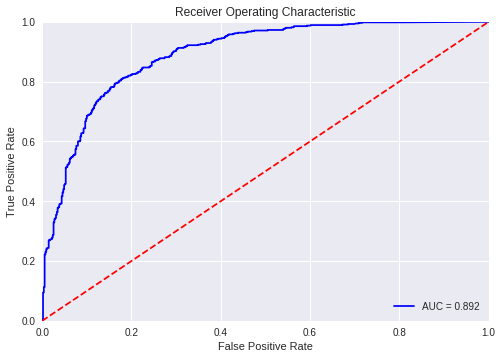

In [10]:
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

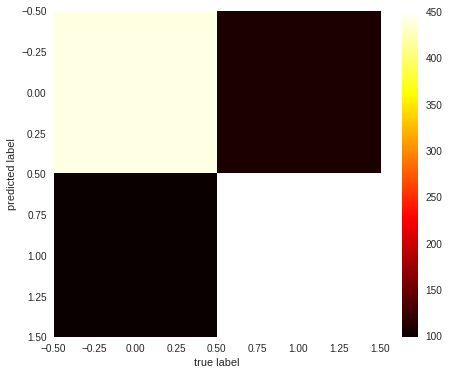

In [11]:
plt.figure(figsize=(8,6))
plt.imshow(y, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [38]:
q = clf.predict_proba(X_test)
q[3:5]

array([[0.46323648, 0.53676352],
       [0.6143384 , 0.3856616 ]])

In [50]:
q = clf.predict_proba(X_test)
testing_output = pd.DataFrame(q, columns = ['zero', 'one'])
Labels = pd.DataFrame(list(range(5500, 7000)))
testing_output['Unique indices'] = Labels

hector = []
for i in range(q.shape[0]):
#   if q[i][0] > q[i][1]:
#     hector.append(0)
#   else:
#     hector.append(1)
  hector.append(np.argmax([testing_output['zero'][i], testing_output['one'][i]], axis = 0))
testing_output['guesses'] = hector
# testing_output

,zero,one,Unique indices,guesses
0,0.807042,0.192958,5500,0
1,0.946183,0.053817,5501,0
2,0.938662,0.061338,5502,0
3,0.463236,0.536764,5503,1
4,0.614338,0.385662,5504,0
5,0.697681,0.302319,5505,0
6,0.933260,0.066740,5506,0
7,0.944939,0.055061,5507,0
8,0.492867,0.507133,5508,1
9,0.537677,0.462323,5509,0


In [0]:
pickle.dump(testing_output, open('Ai3_binary.p', 'wb')) # Creates pickle file in Google Colab but doesn't save to your machine
files.download('Ai3_binary.p') # Saving to pickle file to local drive (should be in Downloads). Send pickle file to beaverworksmedlytics@gmail.com


In [0]:
def testing(test_images):   # Final function to output pandas df of ordered image indexes and their respective guesses
  mostly_blank_feature_list = mostly_blank_feature(test_images)
  true_rows_index, false_rows_index = partition_test(mostly_blank_feature_list, 1)
  
  true_rows_guess = np.array([0] * len(true_rows_index))
  false_rows_guess = np.array([1] * len(false_rows_index))
  
  guesses = np.concatenate((true_rows_guess, false_rows_guess))
  guesses_one_hot = np.eye(2)[guesses] # converting raw guesses (0 or one) to one hot vectors where 0 = [1, 0] and 1 = [0,1] 
  indexes = np.concatenate((np.array(true_rows_index), np.array(false_rows_index)))
  
  output = pd.DataFrame(data={'Guesses': guesses, 'Zero': guesses_one_hot[:,0], 'One': guesses_one_hot[:,1], 'Indexes': indexes}) # creating pandas dataframe of 3 comlumns 
                                                                                                                                  # (indices and probabilities for each class)
  output = output.sort_values('Indexes') # sorting so that the column for image indexes are ordered from 0-499 and they stay with their respective Guesses
  
  output = output.reset_index(drop=True) # Reseting dataframe indices so that they are ordered 0-499
  
  output = output.drop('Indexes', axis = 1)  # Because df indices and images indices columns are now the same we can drop the indexes column
  
  cols = output.columns.tolist()   # Converting columns to lists so they can be reordered as "Guest, Zero, One"
  
  output = output[cols[:1] + cols[2:] + cols[1:2]]  # Reordering columns (you don't have to do this but I wanted to)
  
  output = pd.concat([output, pd.DataFrame(test_images_df.iloc[:, 1])], axis =1)
  
  return(output)

# Example Classifier

Below is an example of a very poor classifier for this dataset. It is a decision tree with just one feature - whether or not the image is mostly blank space or not. It performs with about 72.4% accuracy on the eval data and 64.4% accuracy on the test data. Remember that accuracy is not always the best measure of a classifier!

It's up to you to build a classifier (of any variety) that does a better job!

In [0]:
#######       Example Classifier          ##########

all_training = pd.concat([train_images_df, train_simple_labels], axis = 1)  ## combining images df and label dfs to make one datafram
all_training =  all_training.reindex(np.random.permutation(all_training.index)).drop(['Unique Index'], axis = 1) ## shuffling/randomizing df (Note: I use 0:4000 for training and 4000:5500 for validation)




def mostly_blank_feature(images):  # Feature Extraction
  mbf = []
  # Sample 2000 of 89401 pixels. If half of them are less than 100 (fairly dark) then mostly_blank_feature = 1, else it's 0
  for h in range(len(images)):
    if(sum(np.array(random.sample(list(images[h].reshape([299*299])), 2000)) < 100) > 1000): 
      mbf.append(1)
    else:
      mbf.append(0)
  return(mbf)


def gini(labels):  # Gini Impurity measures how often an element would be incorrectly labeled if it were labeled according to a particular partition
  classes = 2      # (used to measure how good the partition is)
  impurity = 1
  
  for label in range(classes):
    prob_of_label = sum(labels)/float(len(labels))
    impurity -= prob_of_label**2
  return impurity

def partition(feature_list, label_list, feature_value):  # Splits the images by according to some feature value
  true_rows, false_rows = [], []
  true_rows_index, false_rows_index = [], []
  for d in range(len(feature_list)):
    if(feature_list[d] == feature_value):
      true_rows.append(label_list[d])
      true_rows_index.append(d)
    else:
      false_rows.append(label_list[d])
      false_rows_index.append(d)

  return true_rows, false_rows, true_rows_index, false_rows_index

def info_gain(trues, falses, current):  # Measures how much info is gained by partitioning the data in a particular way using Gini Impurity
  p = float(len(trues)) / (len(trues) + len(falses))
  return current - p * gini(trues) - (1 - p) * gini(falses)



    

In [97]:
d = {'train_simple_labels': all_training.iloc[0:4000,1].values.reshape(4000), 'mostly_blank_feature': np.array(mostly_blank_feature(all_training.iloc[0:4000,0].values))} 
df = pd.DataFrame(d)

true_rows, false_rows, true_rows_index, false_rows_index = partition(list(df['mostly_blank_feature']), list(df['train_simple_labels']), 1)
info_gain(false_rows, true_rows, gini(list(df['train_simple_labels'])))   # finding if the partition increases information. It (barely) does, 
                                                                          # so I will use this partition

0.1090753572574053

In [0]:
def tree(eval_images, eval_simple_labels):       # Making tree function that takes Validation data and outputs accuracy
  
  mostly_blank_feature_list = mostly_blank_feature(eval_images)
  true_rows, false_rows, true_rows_index, false_rows_index = partition(mostly_blank_feature_list, eval_simple_labels, 1)
  
  true_rows_guess = np.array([0] * len(true_rows))
  false_rows_guess = np.array([1] * len(false_rows))
    
  correct = 0  
  for i in range(len(true_rows)):
    if(true_rows_guess[i] == true_rows[i]):
      correct += 1
  for h in range(len(false_rows)):
    if(false_rows_guess[h] == false_rows[h]):
      correct += 1
    
  return('accuracy: ' + str(correct/len(eval_simple_labels)))

In [0]:
tree(all_training.iloc[4000:5500, 0].values, all_training.iloc[4000:5500, 1].values) # Evaluating accuracy on validation data with known labels

'accuracy: 0.724'

In [0]:
def partition_test(feature_list, feature_value): 
  
  true_rows_index, false_rows_index = [], []      # New partition function without using labels (only using indexes to keep track of images because test labels are 
                                                  # not available)
  for d in range(len(feature_list)):
    if(feature_list[d] == feature_value):
      true_rows_index.append(d)
    else:
      false_rows_index.append(d)

  return true_rows_index, false_rows_index


####### Look at the function below to see how I got the Pandas dataframe into the right format   #######

def testing(test_images):   # Final function to output pandas df of ordered image indexes and their respective guesses
  mostly_blank_feature_list = mostly_blank_feature(test_images)
  true_rows_index, false_rows_index = partition_test(mostly_blank_feature_list, 1)
  
  true_rows_guess = np.array([0] * len(true_rows_index))
  false_rows_guess = np.array([1] * len(false_rows_index))
  
  guesses = np.concatenate((true_rows_guess, false_rows_guess))
  guesses_one_hot = np.eye(2)[guesses] # converting raw guesses (0 or one) to one hot vectors where 0 = [1, 0] and 1 = [0,1] 
  indexes = np.concatenate((np.array(true_rows_index), np.array(false_rows_index)))
  
  output = pd.DataFrame(data={'Guesses': guesses, 'Zero': guesses_one_hot[:,0], 'One': guesses_one_hot[:,1], 'Indexes': indexes}) # creating pandas dataframe of 3 comlumns 
                                                                                                                                  # (indices and probabilities for each class)
  output = output.sort_values('Indexes') # sorting so that the column for image indexes are ordered from 0-499 and they stay with their respective Guesses
  
  output = output.reset_index(drop=True) # Reseting dataframe indices so that they are ordered 0-499
  
  output = output.drop('Indexes', axis = 1)  # Because df indices and images indices columns are now the same we can drop the indexes column
  
  cols = output.columns.tolist()   # Converting columns to lists so they can be reordered as "Guest, Zero, One"
  
  output = output[cols[:1] + cols[2:] + cols[1:2]]  # Reordering columns (you don't have to do this but I wanted to)
  
  output = pd.concat([output, pd.DataFrame(test_images_df.iloc[:, 1])], axis =1)
  
  return(output)


In [15]:
output = testing(test_images)
pickle.dump(output, open('filename.p', 'wb')) # Creates pickle file in Google Colab but doesn't save to your machine
files.download('filename.p') # Saving to pickle file to local drive (should be in Downloads). Send pickle file to beaverworksmedlytics@gmail.com
output

NameError: ignored

# Submitting Your Model

Once you have finished, run your classifier on the test images and make a pickle file containing a pandas dataframe. Exporting a pickle file to your local drive is demonstrated in the example classifier. 

* First, create a pandas dataframe with 4 columns (or 7 columns for complex lables). One column should contain your best guess at the class of the image and one column should contain the unique index for that image. The other columns should contain the probability that the image is classified in each class. **Make sure the unique indices on your dataframe match the unique indices of the images being predicted. The order of rows and columns do not matter, as long as there are 1500 rows and either 4 or 7 columns (depending on which classifier you have made)**. Run through the example classifier provided to see what the output pandas df looks like if you are confused.
 * If your classifier does not compute the probabilities for each class and simply labels with a 0 or 1 (or 0, 1, 2, 3, 4 for complex labels), the probability for whichever class is predicted is 1.00 and the probability for the other class(es) is(are) 0.00.
* Then download the pandas dataframe as a pickle file using pickle.dump() and files.download().
* Lastly, email the pickle file to beaverworksmedlytics@gmail.com to submit it for evaluation.
 * You can submit up to 3 times before your final evaluation

Your model will be evaluated on Confusion Matrix Score, Area Under the ROC curve (ROCAUC), and creativity. There will be a "winning" group for each of these categories.


# How Your Model Will Be Evaluated

 
* **Confusion Matrix Score**: You will receive a certain number of points for each correct classification and a certain point penalty for each incorrect classification. The point reward scheme is shown below for both binary and multiclass classifiers. This reward scheme punishes less crucial misclassifications (misclassifying a Negative scan as a Benign Calcification) much less than it punishes costly misclassifications (misclassifying a Malgnant Calcification as a Negative). In this way, our evaluation metric reflects the practical needs of the classifier in its application to real-world problems. It is our hope that you keep these differential punishments in mind when creating your classifiers. 


Truth_Col | 0 (Neg) | 1 (BC) | 2 (BM) | 3 (MC) | 4 (MM) |
--- | ---
0 (Neg) | +2 | -1 | -1 | -3 | -3 |
1 (BC) | -2 | +2 | -1 | -3 |-3 |
2 (BM)| -2 | -1 | +2 | -3 | -3 |
3 (MC) | -6 | -4 | -4 | +2 | -2 | 
4 (MM) | -6 | -4 | -4 | -2 | +2 | 


Truth_Col | 0 (Neg) | 1 (Pos)
--- | ---
0 (Neg) | +2 | -3
1 (Pos) |  -6 | +2



* **Area Under ROC Curve:** The receiver operating characteristic (ROC) curve plots the true positive rate (sensitivity/recall) against the false positive rate (fall-out) at many decision threshold settings. The area under the curve (AUC) measures discrimination, the classifier's ability to correctly identify samples from the "positive" and "negative" cases. Intuitively, AUC is the probability that a randomly chosen "positive" sample will be labeled as "more positive" than a randomly chosen "negative" sample. In the case of a multi-class ROC curve, each class is considered separately before taking the weighted average of all the class results. Simply put, the class under consideration is labeled as "positive" while all other classes are labeled as "negative." The AUCROC score should be between 0.5 and 1, in which 0.5 is random classification and 1 is perfect classification.
 * ![alt text](http://fastml.com/images/auc/roc_curve.png)
 * In the image above, the dashed line represents a classifier that classifies based purely on chance. The perfect classifier will have a line that passes through the top left corner of the graph (true positive rate = 1, false positive rate = 0) and will have a ROCAUC (ROC Area Under Curve) of 1. 
 

 
 Using the test data, the example classifier above performs thus on these metrics:
  * Confusion Matrix Score: 706
  * ROCAUC: 0.737
  * Creativity: ZERO!
  
  ![alt text](https://github.com/BeaverWorksMedlytics/Week3_public/blob/master/download111.png?raw=true)
  
   ### Below there is some pseudocode showing how we will calculate these three metrics when evaluating your classifier.

In [0]:
# Confusion Matrix Score for Binary Classifier

binary_confmat_score = np.array([[2, -3],
                                [-6, 2]])

confmat = confusion_matrix(Ground_Truth_Labels, Predicted_Labels) # confusion_matrix is a function from sklearn.metrics and it automatically
                                                                  # constructs a confusion matrix for any number of classes 
                                                                  # Documentation: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
  
confmat_score = np.sum(confmat * binary_confmat_score)


# Confusion Matrix Score for Multiclass Classifier

multiclass_confmat_score = np.array([[2,-1,-1,-3,-3],
                                    [-2,2,-1,-3,-3],
                                    [-2,-1,2,-3,-3],
                                    [-6,-4,-4,2,-2],
                                    [-6,-4,-4,-2,2]])

confmat = confusion_matrix(Ground_Truth_Labels, Predicted_Labels)
  
confmat_score = np.sum(confmat * binary_confmat_score)


      
# ROCAUC for Binary Classifier
false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(Ground_Truth_Labels, Predicted_Labels, pos_label=1)
roc_auc = metrics.auc(false_positive_rate, true_positive_rate)    # roc_curve() and auc() are also functions from sklearn.metrics. roc_curve calculates true and flase positive
                                                                  # rates over many theshold values. pos_label = 1 specifies that in the labels a 1
                                                                  # denotes a positive example (and anything less denotes a negative example). auc() simply calculates the AUC.
                                                                  # Documentation:
                                                                  # roc_curve(): http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
                                                                  # auc(): http://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

# ROCAUC for Multiclass Classifier
  # ROCAUC for multiclass classifiers are calculated by treating each class as a binary classification (this class or all other classes) and micro-averaging 
  # each class's ROCAUC to get a total ROCAUC
false_positive_rat = dict()
true_positive_rate = dict()
roc_auc = dict()
for i in range(5):  # looping through each of 5 classes and getting false and true positive rates and calculating ROCAUC for each class
  fales_positive_rate[i], true_positive_rate[i], _ = roc_curve(Ground_Truth_Labels_OneHot, Prediction_Probabilities) # Because labels are not binary, 
  roc_auc[i] = auc(false_positive_rate[i], true_positive_rate[i])                                                    # they need to be One Hot Vectors (ex. 2 = [0,0,1,0,0])
                                                                                                                     # Prediction_Probabilities are the calculated probabilites
                                                                                                                     # that the example belongs to each of the 5 classes
false_positive_rate["micro"], true_positive_rate["micro"], _ = roc_curve(Ground_Truth_Labels_OneHot.ravel(), Prediction_Probabilities.ravel())
roc_auc = auc(false_positive_rate["micro"], true_positive_rate["micro"]) # micro-averaging averages the ROCAUCs from each class weighted 
                                                                         # according to number of example in that class
   

# Troubleshooting Colab

- If you get an "ResourcesExhausted" error, this means you have used all the GPU resources dedicated to your session and you will need to restart your runtime (Runtime > Restart Runtime). After restarting your runtime your environment will be wiped so you will need to reload the data.

- If you get a warning window that says you are close to reaching the session's memory limit, this means you are nearing a ResourcesExhausted error. You can still run code until the error occurs, but note that you will likely need to restart your runtime soon.

- ResourcesExhausted errors will only occur if you're using GPU support.

- Google Colab will end your runtime automatically after 24 hours

- If things seem really slow, double check that you're using the GPU